In [1]:
opt_bids = [3.8622484787564275 , 2.1216094606111944,  2.347134281066495]
opt_price = 6.321089806558111

In [2]:
import numpy as np
from tqdm import tqdm
from environment import Environment
from learners.ucb_learner import UCB1
from learners.ts_learner import TS_Learner

#Variable initializationion
price = opt_price
T = 365
n_bids = 10 
bids_space = np.linspace(1.0, 10.0, n_bids)
ts_rewards_per_experiment = np.ndarray([])
sols = []
regret = []

#Environment and Learner Creation
env = Environment(noise_variance= 0.05)
ts_learner = TS_Learner(n_arms= n_bids)

for t in tqdm(range(T)):
    #TS learner 
    bid_indx = ts_learner.pull_arm()
    bid = bids_space[bid_indx]
    bids = [bid,bid,bid]
    sols.append(bid)
    reward = env.round(bids,price)
    ts_learner.update(bid_indx, sum(reward))
    regret.append(sum(env.round(opt_bids, opt_price, noise = False)) - sum(reward))



100%|██████████| 365/365 [00:00<00:00, 1240.11it/s]


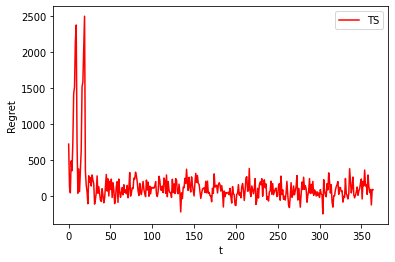

In [3]:
import matplotlib.pyplot as plt 

plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(regret , 'r')
plt.legend(["TS" ])
plt.show()

In [4]:
regret[-10:]

[138.5490173789549,
 156.34406849833067,
 19.88929273017493,
 290.00579493761234,
 131.67869875381348,
 44.15499877934053,
 88.59763279642539,
 -126.22357802324359,
 89.06030137801736,
 85.4314581165122]

In [5]:
sols[-10:]

[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]